<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
n_fold=5
lr=0.001

In [ ]:
import pandas as pd
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv')
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv')

In [ ]:
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols=list(trn.select_dtypes(include=object))
for col in cols:
  le=LabelEncoderExt()
  le.fit(trn[col].astype(str))
  trn[col]=le.transform(trn[col].astype(str))
  tst[col] = tst[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  tst[col]=le.transform(tst[col].astype(str))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
ss=StandardScaler()
frd=trn['isFraud']
ls=list(trn)
trn=ss.fit_transform(trn.drop(['isFraud'],1))
trn=pd.DataFrame(trn)

In [ ]:
ls.remove('isFraud')
trn.columns=ls
trn['isFraud']=frd

ls=list(tst)
tst=ss.fit_transform(tst)
tst=pd.DataFrame(tst)
tst.columns=ls

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 1671.53 MB
Memory usage after optimization is: 417.88 MB
Decreased by 75.0%
Memory usage of dataframe is 1430.33 MB
Memory usage after optimization is: 357.58 MB
Decreased by 75.0%


In [ ]:
trn_n=pd.read_csv('train_transaction.csv.zip')
tst_n=pd.read_csv('test_transaction.csv.zip')
trn['month']=trn_n['TransactionDT']//(86400*30)
trn_n.head()
trn_ls=list(trn_n)
tst_ls=list(tst_n)
for col in trn:
  if col in trn_ls:
    trn[col+'_isna']=trn_n[col].isna().astype('uint8')
for col in tst:
  if col in tst_ls:
    tst[col+'_isna']=tst_n[col].isna().astype('uint8')
import gc
del([trn_n,tst_n])
gc.collect()

0

In [ ]:
trn=trn.drop(['isFraud_isna'],1)

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        if self.ep%10==0:
          y_pred_val = self.model.predict(self.x_val)
          roc_val = roc_auc_score(self.y_val, y_pred_val)
          print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [ ]:
def fl():
    def focal_loss(y_true, y_pred):
        gamma=0.5
        alpha=1-0.036
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss

def load_model():
  K.clear_session()
  inp=Input((593,))
  x=Dense(256,activation='relu')(inp)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  x=BatchNormalization()(x)
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=inp,outputs=x)
  return mod
for en,month in enumerate([(4,5),(4,6),(3,4),(3,5),(3,6)]):
  train=trn.loc[trn['month']>=month[1]]
  test=trn.loc[trn['month']<=month[0]]
  train=train.drop(['month'],1)
  test=test.drop(['month'],1)
  mod=load_model()
  mod.compile(optimizer=Adam(0.00001,decay=1e-3),loss=fl())
  roc = RocCallback(
                  validation_data=(test.drop(['isFraud'],1), test['isFraud']))
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit(train.drop(['isFraud'],1),train['isFraud'],validation_data=(test.drop(['isFraud'],1),test['isFraud']),batch_size=2048,epochs=1000,callbacks=[es,roc])
  del([train,test])
  if en==0:
    pre=mod.predict(tst)/5
    tot=mod.predict(trn.loc[trn['month']==6].drop(['month','isFraud'],1))/5
  else:
    pre+=mod.predict(tst)/5
    tot+=mod.predict(trn.loc[trn['month']==6].drop(['month','isFraud'],1))/5

Epoch 1/1000
47/47 [==============================] - 2s 46ms/step - loss: 89.0216 - val_loss: 65.6012
Epoch 2/1000
47/47 [==============================] - 1s 15ms/step - loss: 83.9005 - val_loss: 63.3218
Epoch 3/1000
47/47 [==============================] - 1s 15ms/step - loss: 81.3210 - val_loss: 61.9699
Epoch 4/1000
47/47 [==============================] - 1s 15ms/step - loss: 78.9447 - val_loss: 61.2191
Epoch 5/1000
47/47 [==============================] - 1s 15ms/step - loss: 79.5740 - val_loss: 60.6934
Epoch 6/1000
47/47 [==============================] - 1s 15ms/step - loss: 76.3411 - val_loss: 60.2437
Epoch 7/1000
47/47 [==============================] - 1s 15ms/step - loss: 76.0745 - val_loss: 59.9301
Epoch 8/1000
47/47 [==============================] - 1s 15ms/step - loss: 74.9312 - val_loss: 59.6105
Epoch 9/1000
47/47 [==============================] - 1s 15ms/step - loss: 74.4927 - val_loss: 59.1810
Epoch 10/1000
47/47 [==============================] - 14s 296ms/step - l

In [30]:
dk.keys()

dict_keys(['0.8842399233615262', '0.8680248437397996', '0.8654564376773441'])

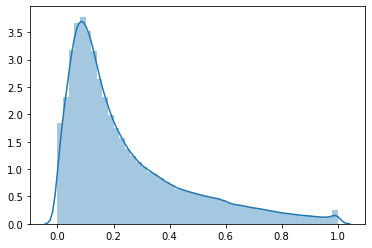

In [31]:
import seaborn as sns
sns.distplot(dk['0.8842399233615262'])

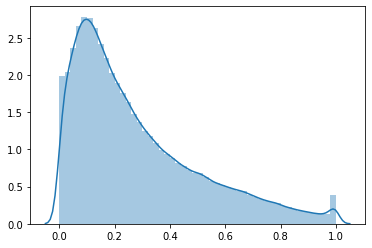

In [32]:

sns.distplot(dk['0.8680248437397996'])

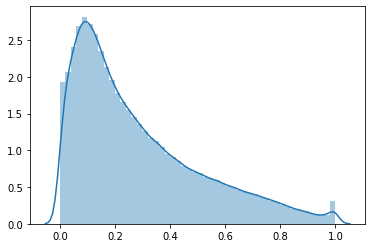

In [33]:

sns.distplot(dk['0.8654564376773441'])